# [Autogen 0.5.5 (stable) setup](https://microsoft.github.io/autogen/stable/user-guide/agentchat-user-guide/installation.html)
## Install OpenAI for Model Client
- To use the OpenAI and Azure OpenAI models, you need to install the following extensions: `pip install "autogen-ext[openai]"`
- If you are using Azure OpenAI with AAD authentication, you need to install the following: `pip install "autogen-ext[azure]"`
- If you want to install both libraries, you maysimply install the following: `pip install "autogen-ext[openai,azure]"`


## Full setup
```
conda env remove -n autogen -y
conda create -n autogen python=3.13 -y
conda activate autogen
pip install -U "autogen-agentchat" "autogen-ext[azure]" "autogen-ext[openai]" python-dotenv jupyter
jupyter kernelspec list
jupyter kernelspec uninstall autogen -y
jupyter kernelspec list
python -m ipykernel install --name autogen --user
```
Other possible libraries: *pyautogen markdownify openai chroma apify-client duckduckgo-search langchain langchain-community*

# Libaries and Constants

In [1]:
# !az login

In [2]:
import os, sys, json, random
import random
from autogen_agentchat.agents import AssistantAgent
from autogen_agentchat.ui import Console
from autogen_ext.models.openai import AzureOpenAIChatCompletionClient
from dotenv import load_dotenv # requires python-dotenv
from common.utils import *

if not load_dotenv("./../../config/credentials_my.env"):
    print("Environment variables not loaded, cell execution stopped")
else:    
    print("Environment variables have been loaded ;-)")

cache_seed = 41 # default seed is 41

temperature = 0.5

data_path = "./data/data.json"

Environment variables have been loaded ;-)


# Data
You may run the following cell multiple times

In [3]:
# Open the JSON file and load its content into the 'topics' variable  

with open(data_path, 'r') as file:  
    topics = json.load(file)
    
topic = topic_to_string(random.choice(topics))
print(topic)

Educazione e formazione:
- Accesso equo all'istruzione
- Innovazione tecnologica nell'educazione
- Alfabetizzazione digitale
- DisparitÃ  educative e inclusione scolastica


# Define a model client

In [4]:
def create_model_client(aad:bool=True):
    if aad:
        from autogen_ext.auth.azure import AzureTokenProvider
        from azure.identity import DefaultAzureCredential
        
        token_provider = AzureTokenProvider(
            DefaultAzureCredential(), 
            "https://cognitiveservices.azure.com/.default")
        
        model_client = AzureOpenAIChatCompletionClient(
            azure_endpoint = os.environ["AZURE_OPENAI_ENDPOINT"],
            azure_deployment = os.environ["MODEL_DEPLOYMENT_NAME"],
            model = os.environ["MODEL_DEPLOYMENT_NAME"], # this is the model of the deployment
            api_version = os.environ["OPENAI_API_VERSION"],            
            azure_ad_token_provider=token_provider,
            seed = cache_seed,
            temperature = temperature,
        )
    else:
        model_client = AzureOpenAIChatCompletionClient(
            azure_endpoint = os.environ["AZURE_OPENAI_ENDPOINT"],
            model = os.environ["MODEL_DEPLOYMENT_NAME"], # this is the model of the deployment
            api_version = os.environ["OPENAI_API_VERSION"],
            api_key=os.environ["AZURE_OPENAI_API_KEY"],
            seed = cache_seed,
            temperature = temperature,
        )

    return model_client
    
model_client = create_model_client(aad=True)
model_client.dump_component()

ComponentModel(provider='autogen_ext.models.openai.AzureOpenAIChatCompletionClient', component_type='model', version=1, component_version=1, description='Chat completion client for Azure OpenAI hosted models.', label='AzureOpenAIChatCompletionClient', config={'seed': 41, 'temperature': 0.5, 'model': 'gpt-4o', 'azure_endpoint': 'https://mmoaiswc-01.openai.azure.com/', 'azure_deployment': 'gpt-4o', 'api_version': '2025-03-01-preview', 'azure_ad_token_provider': {'provider': 'autogen_ext.auth.azure.AzureTokenProvider', 'component_type': 'token_provider', 'version': 1, 'component_version': 1, 'label': 'AzureTokenProvider', 'config': {'provider_kind': 'DefaultAzureCredential', 'scopes': ['https://cognitiveservices.azure.com/.default']}}})

# Two-agent chat
This is the simples form of conversation pattern hwhere two agents chat with each other using Autogen<br/>
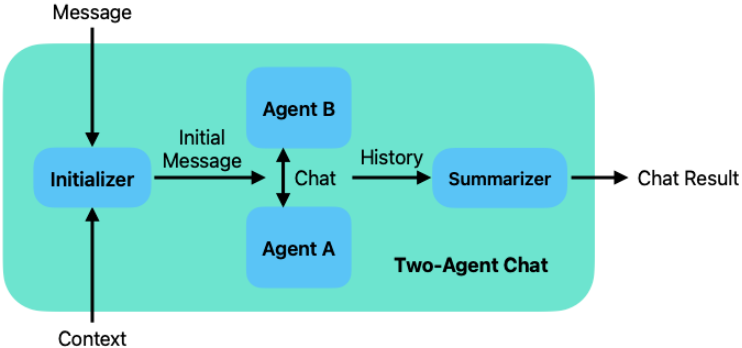

# Create the `first agent`: the **teacher** Agent

In [5]:
teacher_agent = AssistantAgent (
    name = "Teacher_Agent",
    # system_message = "You are a senior teacher who likes teaching his students. Your answers are shorter than 20 words. If a question is about sex, just reply 'REJECTED'",
    system_message = """Sei un insegnante che ama il suo lavoro e rispondere alle domande degli studenti in modo chiaro.
    Le tue ripsoste sono sempre più brevi di 20 parole. 
    Se la domanda riguarda il sesso, rispondi solo 'REJECTED'""",
    model_client = model_client
)
teacher_agent.dump_component()

ComponentModel(provider='autogen_agentchat.agents.AssistantAgent', component_type='agent', version=1, component_version=1, description='An agent that provides assistance with tool use.', label='AssistantAgent', config={'name': 'Teacher_Agent', 'model_client': {'provider': 'autogen_ext.models.openai.AzureOpenAIChatCompletionClient', 'component_type': 'model', 'version': 1, 'component_version': 1, 'description': 'Chat completion client for Azure OpenAI hosted models.', 'label': 'AzureOpenAIChatCompletionClient', 'config': {'seed': 41, 'temperature': 0.5, 'model': 'gpt-4o', 'azure_endpoint': 'https://mmoaiswc-01.openai.azure.com/', 'azure_deployment': 'gpt-4o', 'api_version': '2025-03-01-preview', 'azure_ad_token_provider': {'provider': 'autogen_ext.auth.azure.AzureTokenProvider', 'component_type': 'token_provider', 'version': 1, 'component_version': 1, 'label': 'AzureTokenProvider', 'config': {'provider_kind': 'DefaultAzureCredential', 'scopes': ['https://cognitiveservices.azure.com/.def

# Test the Teacher Agent alone

In [6]:
from autogen_agentchat.messages import TextMessage
from autogen_core import CancellationToken

user_input = ""

while True:
    # user_input = input("User: ")
    # user_input = "How to prove or test that Artificial Intelligence is actually intelligent? Reply in less than 20 words. Just reply 'REJECTED' if the question concerns animals"
    if user_input == "":
        user_input = f"Dato questo tema e sotto-punti, dammi qualche spunto di riflessione in una breve frase discorsiva:\n{topic}"
    response = await teacher_agent.on_messages([TextMessage(content=user_input, source="user")], CancellationToken())    
    print("Teacher:", response.chat_message.to_text())
    print("\n\nPlease type something to ask another question, or leave it blank to move to the next cell")
    user_input = input("User:")
    if user_input == "":
        print("Enjoy continuing to run this notebook!")
        break

Teacher: L'istruzione equa, potenziata dalla tecnologia, promuove inclusione e alfabetizzazione digitale, riducendo le disparità educative globali.


Please type something to ask another question, or leave it blank to move to the next cell


User: 


Enjoy continuing to run this notebook!


# Create the `first agent`: the **student** Agent

In [7]:
student_agent = AssistantAgent (
    name = "Student_Agent",
    #system_message = "You are a student willing to learn. You ask meaningful and precise follow-up questions and are eager to learn more. Your questions are shorter than 20 words.",
    system_message = """Sei uno studente curioso e intelligente che fa domande puntuali e precise 
    nel merito dell'informazione che hai ricevuto in risposta ad una precedente domanda.
    Le tue domande sono più corte di 20 parole""",
    model_client = model_client
)

# Termination condition

In [8]:
from autogen_agentchat.conditions import TextMentionTermination
# The termination condition is a text termination, which will cause the chat to terminate when the text reported below is received.
termination = TextMentionTermination("REJECTED")

# Group chat

In [9]:
from autogen_agentchat.teams import RoundRobinGroupChat

# The group chat will alternate between the writer and the critic.
group_chat = RoundRobinGroupChat([teacher_agent, student_agent], termination_condition=termination, max_turns=10)

# task="In Machine Learning, is logistic regression a real regression algorythm?"
task = f"Dato questo tema e sotto-temi, dammi qualche  elemento di riflessione, usando frasi discorsive con meno di 20 parole: \n{topic_to_string(random.choice(topics))}"

# `run_stream` returns an async generator to stream the intermediate messages.
stream = group_chat.run_stream(task=task)

result = await Console(stream)

---------- TextMessage (user) ----------
Dato questo tema e sotto-temi, dammi qualche  elemento di riflessione, usando frasi discorsive con meno di 20 parole: 
Migrazione e integrazione:
- Politiche migratorie e asilo
- Integrazione dei migranti
- Crisi dei rifugiati
- Traffico di esseri umani
---------- TextMessage (Teacher_Agent) ----------
Politiche migratorie giuste favoriscono l'integrazione, affrontando crisi dei rifugiati e combattendo il traffico di esseri umani.
---------- TextMessage (Student_Agent) ----------
Quali sono le principali sfide delle politiche migratorie attuali?
---------- TextMessage (Teacher_Agent) ----------
Gestione dei flussi, integrazione efficace e protezione dei diritti umani sono le principali sfide delle politiche migratorie attuali.
---------- TextMessage (Student_Agent) ----------
Quali strategie migliorano l'integrazione dei migranti?
---------- TextMessage (Teacher_Agent) ----------
Educazione, opportunità lavorative e programmi di inclusione cultu